# Frequency correlation plots for natural populations with nested clades

Example code for how to calculate frequency correlation plots from augur forecasting builds.

In [317]:
import altair as alt
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np
import pandas as pd
from scipy.stats import pearsonr
import seaborn as sns

%matplotlib inline

In [318]:
sns.set_style("white")
plt.style.use("huddlej")

In [319]:
mpl.rcParams['savefig.dpi'] = 200
mpl.rcParams['figure.dpi'] = 200
mpl.rcParams['font.weight'] = 300
mpl.rcParams['axes.labelweight'] = 300
mpl.rcParams['font.size'] = 18

In [320]:
!pwd

/Users/jlhudd/projects/nextstrain/flu-forecasting/analyses


In [5]:
def matthews_correlation_coefficient(tp, tn, fp, fn):
    """Return Matthews correlation coefficient for values from a confusion matrix.
    Implementation is based on the definition from wikipedia:

    https://en.wikipedia.org/wiki/Matthews_correlation_coefficient
    """
    numerator = (tp * tn) - (fp * fn)
    denominator = np.sqrt((tp + fp) * (tp + fn) * (tn + fp) * (tn + fn))
    if denominator == 0:
            denominator = 1

    return float(numerator) / denominator

def get_matthews_correlation_coefficient_for_data_frame(freq_df, return_confusion_matrix=False):
        """Calculate Matthew's correlation coefficient from a given pandas data frame
        with columns for initial, observed, and predicted frequencies.
        """
        observed_growth = (freq_df["frequency_final"] > freq_df["frequency"])
        predicted_growth = (freq_df["projected_frequency"] > freq_df["frequency"])
        true_positives = ((observed_growth) & (predicted_growth)).sum()
        false_positives= ((~observed_growth) & (predicted_growth)).sum()

        observed_decline = (freq_df["frequency_final"] <= freq_df["frequency"])
        predicted_decline = (freq_df["projected_frequency"] <= freq_df["frequency"])
        true_negatives = ((observed_decline) & (predicted_decline)).sum()
        false_negatives = ((~observed_decline) & (predicted_decline)).sum()

        mcc = matthews_correlation_coefficient(
            true_positives,
            true_negatives,
            false_positives,
            false_negatives
        )

        if return_confusion_matrix:
            confusion_matrix = {
                "tp": true_positives,
                "tn": true_negatives,
                "fp": false_positives,
                "fn": false_negatives
            }
            
            return mcc, confusion_matrix
        else:
            return mcc

## Load data

In [324]:
data_root = "../results/builds/natural/natural_sample_0_with_90_vpm_sliding/"

In [323]:
first_validation_timepoint = "2005-10-01"

In [325]:
tips = pd.read_csv(
    "%s/tip_attributes_with_weighted_distances.tsv" % data_root,
    sep="\t",
    parse_dates=["timepoint"],
    usecols=["strain", "timepoint", "frequency"]
)

In [326]:
tips = tips.query("timepoint >= '%s'" % first_validation_timepoint).copy()

In [327]:
tips.head(1)

,strain,timepoint,frequency
3391,A/Aichi/113/2005,2005-10-01,0.000032


In [334]:
tips.shape

(12139, 3)

In [329]:
tips_to_clades = pd.read_csv("%s/tips_to_clades.tsv" % data_root, sep="\t", parse_dates=["timepoint"])

In [330]:
tips_to_clades = tips_to_clades.query("timepoint >= '%s'" % first_validation_timepoint).copy()

In [331]:
tips_to_clades = tips_to_clades.rename(columns={"tip": "strain"})

In [332]:
tips_to_clades.head()

,strain,clade_membership,depth,timepoint
217229,A/Guangzhou/98/2000,fd5608c,0,2005-10-01
217230,A/Taiwan/511/1999,8fd14cc,0,2005-10-01
217231,A/Taiwan/511/1999,6335574,2,2005-10-01
217232,A/Taiwan/511/1999,fd5608c,4,2005-10-01
217233,A/Taiwan/206/2000,8fd14cc,0,2005-10-01


In [333]:
tips_to_clades.shape

(1157738, 4)

In [335]:
forecasts = pd.read_csv(
    "%s/forecasts.tsv" % data_root,
    sep="\t",
    parse_dates=["timepoint"],
    usecols=["timepoint", "strain", "frequency", "projected_frequency"]
)

In [336]:
forecasts.head(1)

,timepoint,strain,frequency,projected_frequency
0,1998-10-01,A/Christchurch/45/1998,0.031388,0.00165


In [337]:
forecasts.shape

(15530, 4)

In [338]:
full_forecasts = pd.read_csv(
    "%s/forecasts.tsv" % data_root,
    sep="\t",
    parse_dates=["timepoint", "future_timepoint"]
)

In [339]:
full_forecasts = full_forecasts.query("timepoint >= '%s'" % first_validation_timepoint).copy()

## Find large clades

Find all clades with an initial frequency some minimum value (e.g., >15%).

In [341]:
clade_tip_initial_frequencies = tips_to_clades.merge(
    tips,
    on=["timepoint", "strain"]
)

In [342]:
clade_tip_initial_frequencies["future_timepoint"] = clade_tip_initial_frequencies["timepoint"] + pd.DateOffset(months=12)

In [343]:
clade_tip_initial_frequencies.head()

,strain,clade_membership,depth,timepoint,frequency,future_timepoint
0,A/India/D058687/2005,bf71681,0,2005-10-01,0.00001,2006-10-01
1,A/India/D058687/2005,fbbd597,2,2005-10-01,0.00001,2006-10-01
2,A/India/D058687/2005,054ca27,14,2005-10-01,0.00001,2006-10-01
3,A/India/D058687/2005,5bed3da,15,2005-10-01,0.00001,2006-10-01
4,A/India/D058687/2005,05a6dc1,17,2005-10-01,0.00001,2006-10-01


In [492]:
tips_to_clades.query("clade_membership == '3c0baec' & timepoint == '2008-10-01'").head()

,strain,clade_membership,depth,timepoint
497476,A/England/613446/2006,3c0baec,0,2008-10-01
497492,A/England/55243/2005,3c0baec,0,2008-10-01
497508,A/Johannesburg/503/2006,3c0baec,0,2008-10-01
497524,A/Johannesburg/245/2006,3c0baec,0,2008-10-01
497541,A/India/P0614474/2006,3c0baec,2,2008-10-01


In [493]:
tips_to_clades.query("clade_membership == '3c0baec' & timepoint == '2008-10-01'").shape

(269, 4)

In [489]:
clade_tip_initial_frequencies.query("clade_membership == '3c0baec' & timepoint == '2008-10-01'")

,strain,clade_membership,depth,timepoint,frequency,future_timepoint
45776,A/Kisii/6569/2008,3c0baec,3,2008-10-01,0.001259,2009-10-01


In [344]:
initial_clade_frequencies = clade_tip_initial_frequencies.groupby([
    "timepoint", "future_timepoint", "clade_membership"
])["frequency"].sum().reset_index()

In [345]:
initial_clade_frequencies.head()

,timepoint,future_timepoint,clade_membership,frequency
0,2005-10-01,2006-10-01,0252ba2,0.021212
1,2005-10-01,2006-10-01,02b4cfc,0.005199
2,2005-10-01,2006-10-01,048f8ca,0.021212
3,2005-10-01,2006-10-01,054ca27,0.021212
4,2005-10-01,2006-10-01,058a85c,0.004405


In [254]:
initial_clade_frequencies.query("clade_membership == 'cb64469'")

,timepoint,future_timepoint,clade_membership,frequency
315,2024-04-01,2025-04-01,cb64469,0.044085
500,2024-10-01,2025-10-01,cb64469,0.405997
705,2025-04-01,2026-04-01,cb64469,0.675714
889,2025-10-01,2026-10-01,cb64469,0.900193
1046,2026-04-01,2027-04-01,cb64469,0.999877
1220,2026-10-01,2027-10-01,cb64469,0.999977
1401,2027-04-01,2028-04-01,cb64469,0.999968
1582,2027-10-01,2028-10-01,cb64469,0.999980
1794,2028-04-01,2029-04-01,cb64469,0.999943
2019,2028-10-01,2029-10-01,cb64469,0.999949


Merge clade frequencies between adjacent years.

In [346]:
initial_and_observed_clade_frequencies = initial_clade_frequencies.merge(
    initial_clade_frequencies,
    left_on=["future_timepoint", "clade_membership"],
    right_on=["timepoint", "clade_membership"],
    suffixes=["", "_final"]
).groupby(["timepoint", "clade_membership", "frequency"])["frequency_final"].sum().reset_index()

In [256]:
initial_and_observed_clade_frequencies.query("clade_membership == 'cb64469'")

,timepoint,clade_membership,frequency,frequency_final
60,2024-04-01,cb64469,0.044085,0.675714
93,2024-10-01,cb64469,0.405997,0.900193
121,2025-04-01,cb64469,0.675714,0.999877
144,2025-10-01,cb64469,0.900193,0.999977
171,2026-04-01,cb64469,0.999877,0.999968
205,2026-10-01,cb64469,0.999977,0.999980
249,2027-04-01,cb64469,0.999968,0.999943
291,2027-10-01,cb64469,0.999980,0.999949
341,2028-04-01,cb64469,0.999943,0.999987
386,2028-10-01,cb64469,0.999949,0.999965


Select clades with an initial frequency >15%.

In [436]:
large_clades = initial_and_observed_clade_frequencies.query("frequency > 0.15").copy()

In [437]:
large_clades.head()

,timepoint,clade_membership,frequency,frequency_final
0,2005-10-01,26f855a,0.572141,0.946808
1,2005-10-01,2806112,0.231124,0.001333
4,2005-10-01,412c00a,0.978610,1.000002
5,2005-10-01,44989e1,0.966999,1.000002
6,2005-10-01,4e35443,0.978764,1.000002


In [438]:
large_clades.tail()

,timepoint,clade_membership,frequency,frequency_final
558,2014-10-01,bc4cbe3,0.999987,0.999997
560,2014-10-01,c9346ca,0.400579,0.064977
563,2014-10-01,ea08d9e,0.230692,0.885642
565,2014-10-01,f14fabc,0.242212,0.885642
566,2014-10-01,f2ec31a,0.999942,0.999997


In [439]:
large_clades.shape

(256, 4)

In [440]:
large_clades["observed_growth_rate"] = (large_clades["frequency_final"] / large_clades["frequency"])

In [441]:
large_clades.head()

,timepoint,clade_membership,frequency,frequency_final,observed_growth_rate
0,2005-10-01,26f855a,0.572141,0.946808,1.654851
1,2005-10-01,2806112,0.231124,0.001333,0.005767
4,2005-10-01,412c00a,0.978610,1.000002,1.021860
5,2005-10-01,44989e1,0.966999,1.000002,1.034129
6,2005-10-01,4e35443,0.978764,1.000002,1.021699


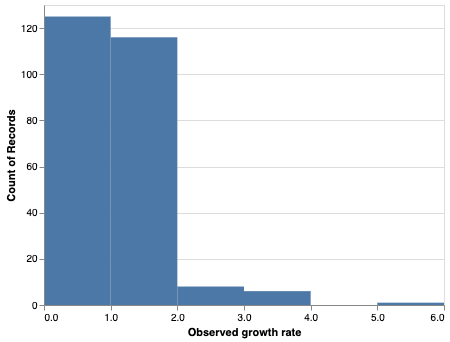

In [442]:
alt.Chart(large_clades).mark_rect().encode(
    x=alt.X("observed_growth_rate:Q", bin=True, title="Observed growth rate"),
    y="count()"
)

## Find estimated future frequencies of large clades

Use the true fitness metric for forecasts.

In [443]:
clade_tip_estimated_frequencies = tips_to_clades.merge(
    forecasts,
    on=["timepoint", "strain"]
)

In [444]:
clade_tip_estimated_frequencies.head()

,strain,clade_membership,depth,timepoint,frequency,projected_frequency
0,A/India/D058687/2005,bf71681,0,2005-10-01,0.00001,2.014381e-08
1,A/India/D058687/2005,fbbd597,2,2005-10-01,0.00001,2.014381e-08
2,A/India/D058687/2005,054ca27,14,2005-10-01,0.00001,2.014381e-08
3,A/India/D058687/2005,5bed3da,15,2005-10-01,0.00001,2.014381e-08
4,A/India/D058687/2005,05a6dc1,17,2005-10-01,0.00001,2.014381e-08


In [445]:
estimated_clade_frequencies = clade_tip_estimated_frequencies.groupby(
    ["timepoint", "clade_membership"]
).aggregate({"projected_frequency": "sum"}).reset_index()

In [446]:
estimated_clade_frequencies.head()

,timepoint,clade_membership,projected_frequency
0,2005-10-01,0252ba2,0.000490
1,2005-10-01,02b4cfc,0.000052
2,2005-10-01,048f8ca,0.000490
3,2005-10-01,054ca27,0.000490
4,2005-10-01,058a85c,0.000138


In [447]:
complete_clade_frequencies = large_clades.merge(
    estimated_clade_frequencies,
    on=["timepoint", "clade_membership"],
    suffixes=["", "_other"]
)

In [448]:
complete_clade_frequencies["estimated_growth_rate"] = (
    complete_clade_frequencies["projected_frequency"] / complete_clade_frequencies["frequency"]
)

In [449]:
complete_clade_frequencies["year"] = complete_clade_frequencies["timepoint"].dt.year

In [450]:
complete_clade_frequencies.head()

,timepoint,clade_membership,frequency,frequency_final,observed_growth_rate,projected_frequency,estimated_growth_rate,year
0,2005-10-01,26f855a,0.572141,0.946808,1.654851,0.834142,1.457931,2005
1,2005-10-01,2806112,0.231124,0.001333,0.005767,0.144996,0.627350,2005
2,2005-10-01,412c00a,0.978610,1.000002,1.021860,0.999504,1.021350,2005
3,2005-10-01,44989e1,0.966999,1.000002,1.034129,0.997232,1.031264,2005
4,2005-10-01,4e35443,0.978764,1.000002,1.021699,0.999510,1.021196,2005


In [451]:
complete_clade_frequencies.shape

(256, 8)

In [452]:
r, p = pearsonr(
    complete_clade_frequencies["observed_growth_rate"],
    complete_clade_frequencies["estimated_growth_rate"]
)

In [453]:
r

0.38968967545539396

In [454]:
p

1.0348377626546113e-10

In [455]:
mcc, confusion_matrix = get_matthews_correlation_coefficient_for_data_frame(complete_clade_frequencies, True)

In [456]:
mcc

0.512316851431407

In [481]:
confusion_matrix

{'tp': 127, 'tn': 59, 'fp': 66, 'fn': 4}

In [482]:
sum(confusion_matrix.values())

256

In [457]:
growth_accuracy = confusion_matrix["tp"] / float(confusion_matrix["tp"] + confusion_matrix["fp"])
growth_accuracy

0.6580310880829016

In [458]:
decline_accuracy = confusion_matrix["tn"] / float(confusion_matrix["tn"] + confusion_matrix["fn"])
decline_accuracy

0.9365079365079365

In [459]:
min_growth_rate = 0
max_growth_rate = complete_clade_frequencies.loc[:, ["observed_growth_rate", "estimated_growth_rate"]].max().max() + 0.2

In [460]:
pseudofrequency = 0.001

In [461]:
complete_clade_frequencies["log_observed_growth_rate"] = (
    np.log10((complete_clade_frequencies["frequency_final"] + pseudofrequency) / (complete_clade_frequencies["frequency"] + pseudofrequency))
)

complete_clade_frequencies["log_estimated_growth_rate"] = (
    np.log10((complete_clade_frequencies["projected_frequency"] + pseudofrequency) / (complete_clade_frequencies["frequency"] + pseudofrequency))
)

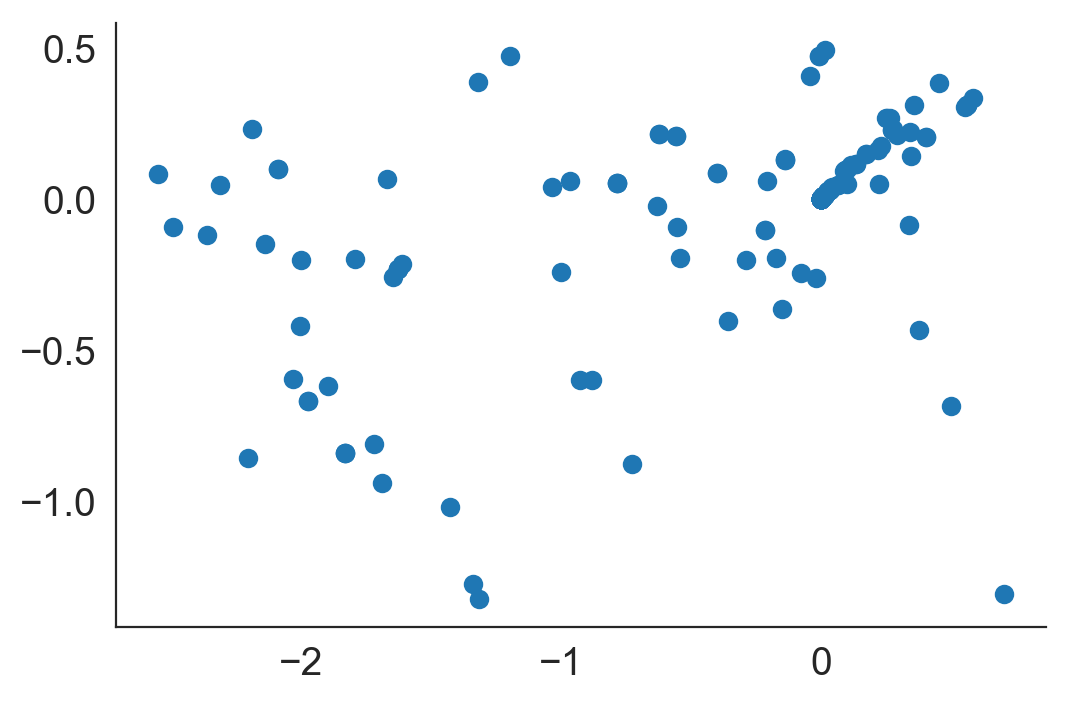

In [462]:
plt.plot(complete_clade_frequencies["log_observed_growth_rate"], complete_clade_frequencies["log_estimated_growth_rate"], "o")

In [463]:
#complete_clade_frequencies["log_observed_growth_rate"] = np.log(complete_clade_frequencies["observed_growth_rate"])
#complete_clade_frequencies["log_estimated_growth_rate"] = np.log(complete_clade_frequencies["estimated_growth_rate"])

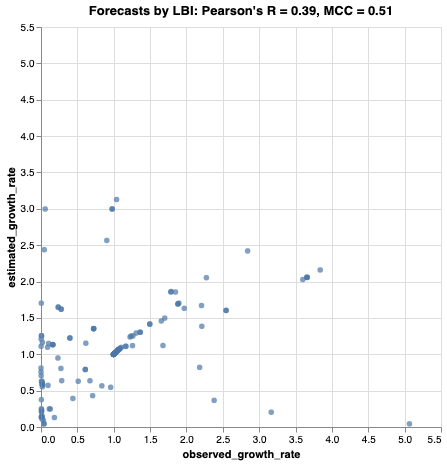

In [464]:
tooltip_attributes = ["observed_growth_rate:Q", "estimated_growth_rate:Q", "timepoint:N", "frequency:Q", "frequency_final:Q",
                      "projected_frequency:Q", "clade_membership:N"]

chart = alt.Chart(complete_clade_frequencies).mark_circle().encode(
    alt.X("observed_growth_rate:Q", scale=alt.Scale(domain=(min_growth_rate, max_growth_rate))),
    alt.Y("estimated_growth_rate:Q", scale=alt.Scale(domain=(min_growth_rate, max_growth_rate))),
    alt.Tooltip(tooltip_attributes)
).properties(
    width=400,
    height=400,
    title="Forecasts by LBI: Pearson's R = %.2f, MCC = %.2f" % (r, mcc)
)

#chart.save("forecast_growth_correlation_natural_lbi.svg")
chart

In [465]:
complete_clade_frequencies.head()

,timepoint,clade_membership,frequency,frequency_final,observed_growth_rate,projected_frequency,estimated_growth_rate,year,log_observed_growth_rate,log_estimated_growth_rate
0,2005-10-01,26f855a,0.572141,0.946808,1.654851,0.834142,1.457931,2005,0.218459,0.163499
1,2005-10-01,2806112,0.231124,0.001333,0.005767,0.144996,0.627350,2005,-1.997805,-0.201380
2,2005-10-01,412c00a,0.978610,1.000002,1.021860,0.999504,1.021350,2005,0.009382,0.009166
3,2005-10-01,44989e1,0.966999,1.000002,1.034129,0.997232,1.031264,2005,0.014560,0.013356
4,2005-10-01,4e35443,0.978764,1.000002,1.021699,0.999510,1.021196,2005,0.009313,0.009100


In [466]:
upper_limit = np.ceil(complete_clade_frequencies.loc[:, ["observed_growth_rate", "estimated_growth_rate"]].max().max())

log_lower_limit = complete_clade_frequencies.loc[:, ["log_observed_growth_rate", "log_estimated_growth_rate"]].min().min() - 0.1
log_upper_limit = np.ceil(complete_clade_frequencies.loc[:, ["log_observed_growth_rate", "log_estimated_growth_rate"]].max().max()) + 0.1

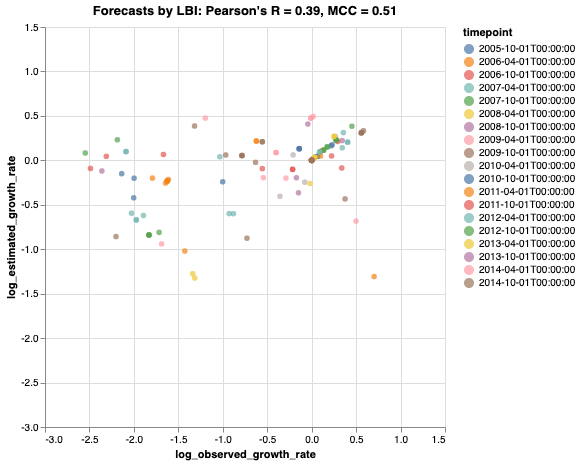

In [467]:
tooltip_attributes = ["observed_growth_rate:Q", "estimated_growth_rate:Q", "timepoint:N", "frequency:Q", "frequency_final:Q",
                      "projected_frequency:Q", "clade_membership:N"]

chart = alt.Chart(complete_clade_frequencies).mark_circle().encode(
    alt.X("log_observed_growth_rate:Q", scale=alt.Scale(domain=(log_lower_limit, log_upper_limit))),
    alt.Y("log_estimated_growth_rate:Q", scale=alt.Scale(domain=(log_lower_limit, log_upper_limit))),
    alt.Color("timepoint:N"),
    alt.Tooltip(tooltip_attributes)
).properties(
    width=400,
    height=400,
    title="Forecasts by LBI: Pearson's R = %.2f, MCC = %.2f" % (r, mcc)
).interactive()

#chart.save("forecast_log_growth_correlation_natural_lbi.svg")
chart

In [468]:
log_lower_limit

-2.6466797297509754

In [469]:
complete_clade_frequencies.loc[:, ["log_observed_growth_rate", "log_estimated_growth_rate"]].min().min()

-2.5466797297509753

In [470]:
r, p = pearsonr(
    complete_clade_frequencies["log_observed_growth_rate"],
    complete_clade_frequencies["log_estimated_growth_rate"]
)

In [471]:
r

0.4734458852000844

In [472]:
p

1.0467497294492263e-15

In [473]:
pearsonr(
    complete_clade_frequencies["observed_growth_rate"],
    complete_clade_frequencies["estimated_growth_rate"]
)

(0.38968967545539396, 1.0348377626546113e-10)

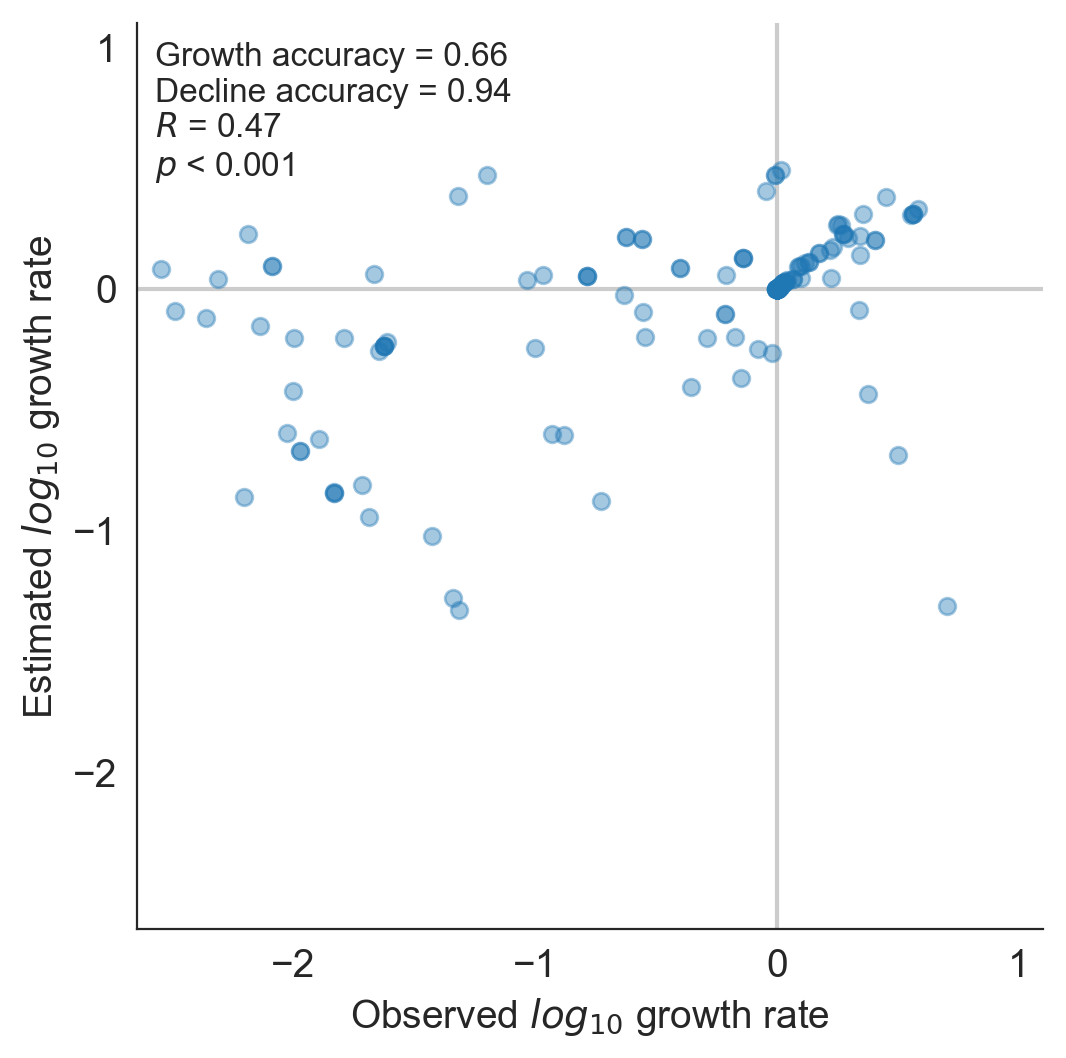

In [474]:
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
ax.plot(
    complete_clade_frequencies["log_observed_growth_rate"],
    complete_clade_frequencies["log_estimated_growth_rate"],
    "o",
    alpha=0.4
)

ax.axhline(color="#cccccc", zorder=-5)
ax.axvline(color="#cccccc", zorder=-5)

if p < 0.001:
    p_value = "$p$ < 0.001"
else:
    p_value = "$p$ = %.3f" % p

ax.text(
    0.02,
    0.9,
    "Growth accuracy = %.2f\nDecline accuracy = %.2f\n$R$ = %.2f\n%s" % (growth_accuracy, decline_accuracy, r, p_value),
    fontsize=12,
    horizontalalignment="left",
    verticalalignment="center",
    transform=ax.transAxes
)

ax.set_xlabel("Observed $log_{10}$ growth rate")
ax.set_ylabel("Estimated $log_{10}$ growth rate")

ticks = np.arange(-6, 4, 1)
ax.set_xticks(ticks)
ax.set_yticks(ticks)

ax.set_xlim(log_lower_limit, log_upper_limit)
ax.set_ylim(log_lower_limit, log_upper_limit)
ax.set_aspect("equal")

#plt.savefig("../manuscript/figures/validation-of-best-model-for-natural-populations.pdf")

## Estimated and observed closest strains per timepoint

Create a figure similar to Figure 2D in Neher et al. 2014 showing the minimum estimated distance to the future and minimum observed distance to the future per timepoint.

In [475]:
sorted_df = full_forecasts.dropna().sort_values(
    ["timepoint"]
).copy()

In [476]:
sorted_df["timepoint_rank"] = sorted_df.groupby("timepoint")["weighted_distance_to_future"].rank(pct=True)

In [477]:
best_fitness_rank_by_timepoint_df = sorted_df.sort_values(
    ["timepoint", "fitness"],
    ascending=False
).groupby("timepoint")["timepoint_rank"].first().reset_index()

In [478]:
best_fitness_rank_by_timepoint_df.head()

,timepoint,timepoint_rank
0,2005-10-01,0.115217
1,2006-04-01,0.118863
2,2006-10-01,0.294737
3,2007-04-01,0.086605
4,2007-10-01,0.315565


Text(0,0.5,'Number of timepoints')

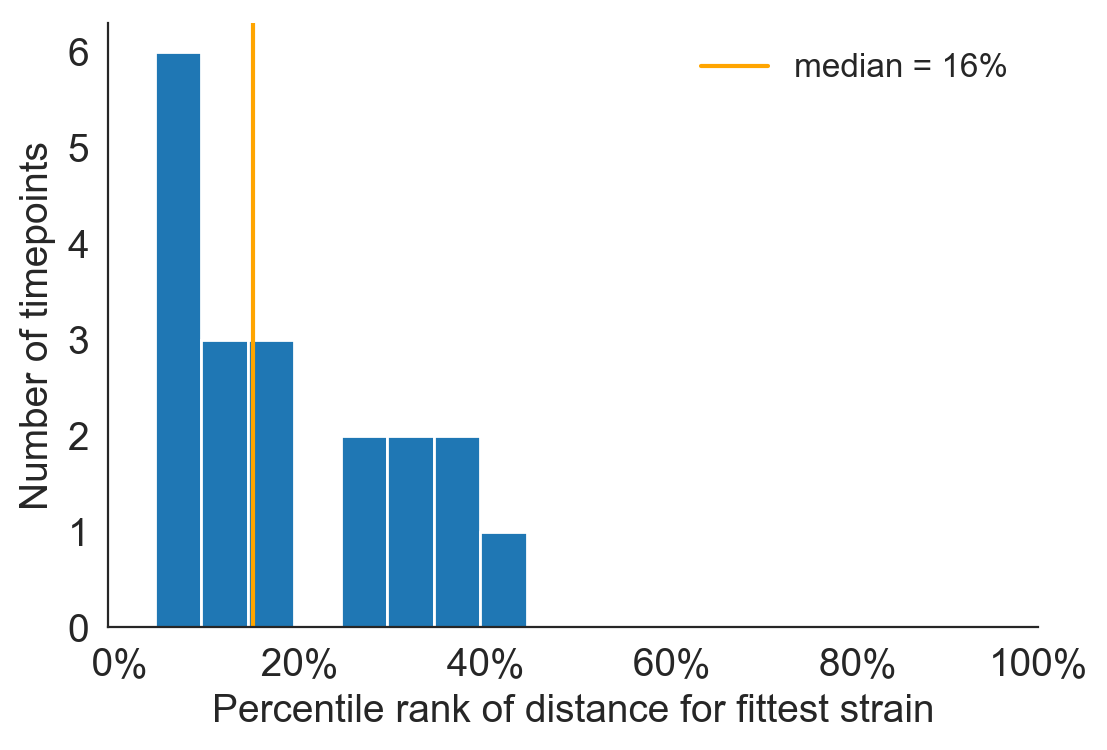

In [479]:
median_best_rank = best_fitness_rank_by_timepoint_df["timepoint_rank"].median()

fig, ax = plt.subplots(1, 1, figsize=(6, 4))
ax.hist(best_fitness_rank_by_timepoint_df["timepoint_rank"], bins=np.arange(0, 1.01, 0.05), label=None)
ax.axvline(
    median_best_rank,
    color="orange",
    label="median = %i%%" % round(median_best_rank * 100, 0)
)
ax.set_xticklabels(['{:3.0f}%'.format(x*100) for x in [0, 0.2, 0.4, 0.6, 0.8, 1.0]])
ax.set_xlim(0, 1)

ax.legend(
    frameon=False
)
ax.set_xlabel("Percentile rank of distance for fittest strain")
ax.set_ylabel("Number of timepoints")

## Merge validation figures into subpanels of one figure

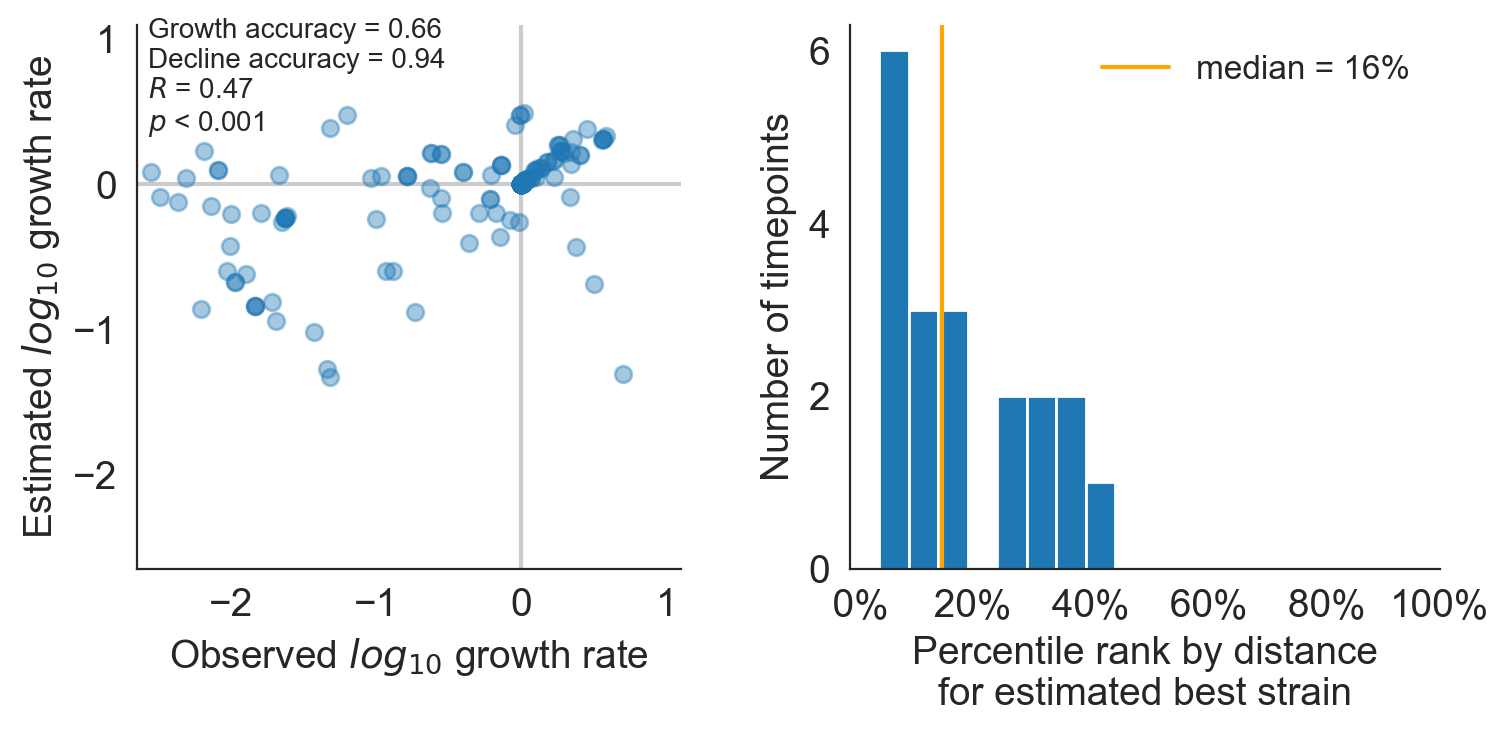

In [480]:
fig = plt.figure(figsize=(8, 4), facecolor='w')
gs = gridspec.GridSpec(1, 2, width_ratios=[1, 1], wspace=0.1)

#
# Clade growth rate correlations
#

clade_ax = fig.add_subplot(gs[0])
clade_ax.plot(
    complete_clade_frequencies["log_observed_growth_rate"],
    complete_clade_frequencies["log_estimated_growth_rate"],
    "o",
    alpha=0.4
)

clade_ax.axhline(color="#cccccc", zorder=-5)
clade_ax.axvline(color="#cccccc", zorder=-5)

if p < 0.001:
    p_value = "$p$ < 0.001"
else:
    p_value = "$p$ = %.3f" % p

clade_ax.text(
    0.02,
    0.9,
    "Growth accuracy = %.2f\nDecline accuracy = %.2f\n$R$ = %.2f\n%s" % (growth_accuracy, decline_accuracy, r, p_value),
    fontsize=10,
    horizontalalignment="left",
    verticalalignment="center",
    transform=clade_ax.transAxes
)

clade_ax.set_xlabel("Observed $log_{10}$ growth rate")
clade_ax.set_ylabel("Estimated $log_{10}$ growth rate")

ticks = np.arange(-6, 4, 1)
clade_ax.set_xticks(ticks)
clade_ax.set_yticks(ticks)

clade_ax.set_xlim(log_lower_limit, log_upper_limit)
clade_ax.set_ylim(log_lower_limit, log_upper_limit)
clade_ax.set_aspect("equal")

#
# Estimated closest strain to the future ranking
#

rank_ax = fig.add_subplot(gs[1])

median_best_rank = best_fitness_rank_by_timepoint_df["timepoint_rank"].median()

rank_ax.hist(best_fitness_rank_by_timepoint_df["timepoint_rank"], bins=np.arange(0, 1.01, 0.05), label=None)
rank_ax.axvline(
    median_best_rank,
    color="orange",
    label="median = %i%%" % round(median_best_rank * 100, 0)
)
rank_ax.set_xticklabels(['{:3.0f}%'.format(x*100) for x in [0, 0.2, 0.4, 0.6, 0.8, 1.0]])
rank_ax.set_xlim(0, 1)

rank_ax.legend(
    frameon=False
)
rank_ax.set_xlabel("Percentile rank by distance\nfor estimated best strain")
rank_ax.set_ylabel("Number of timepoints")

gs.tight_layout(fig)

plt.savefig("../manuscript/figures/validation-of-best-model-for-natural-populations.png")

In [484]:
complete_clade_frequencies.query("frequency > 0.5 & frequency_final < 0.01")

,timepoint,clade_membership,frequency,frequency_final,observed_growth_rate,projected_frequency,estimated_growth_rate,year,log_observed_growth_rate,log_estimated_growth_rate
45,2007-04-01,3c0baec,0.749524,0.005121,0.006832,0.940363,1.254614,2007,-2.088542,0.098393
58,2007-04-01,ac68424,0.749524,0.005121,0.006832,0.940363,1.254614,2007,-2.088542,0.098393
63,2007-10-01,3c0baec,0.794419,0.001259,0.001585,0.960983,1.209668,2007,-2.546680,0.082571
184,2012-10-01,6c1138e,0.523283,0.002415,0.004615,0.891225,1.703142,2012,-2.186175,0.230909


In [485]:
complete_clade_frequencies.query("clade_membership == '3c0baec'")

,timepoint,clade_membership,frequency,frequency_final,observed_growth_rate,projected_frequency,estimated_growth_rate,year,log_observed_growth_rate,log_estimated_growth_rate
30,2006-10-01,3c0baec,0.473712,0.794419,1.677008,0.530804,1.120520,2006,0.224166,4.932102e-02
45,2007-04-01,3c0baec,0.749524,0.005121,0.006832,0.940363,1.254614,2007,-2.088542,9.839274e-02
63,2007-10-01,3c0baec,0.794419,0.001259,0.001585,0.960983,1.209668,2007,-2.546680,8.257142e-02
99,2009-04-01,3c0baec,0.999987,1.000002,1.000015,1.000000,1.000013,2009,0.000007,5.640225e-06
107,2009-10-01,3c0baec,0.999961,0.999932,0.999971,1.000000,1.000039,2009,-0.000013,1.692089e-05
120,2010-04-01,3c0baec,1.000002,0.999983,0.999981,1.000000,0.999998,2010,-0.000008,-8.677204e-07
133,2010-10-01,3c0baec,0.999932,0.999981,1.000049,1.000000,1.000068,2010,0.000021,2.950352e-05
159,2011-10-01,3c0baec,0.999981,0.996469,0.996488,1.000000,1.000019,2011,-0.001526,8.243430e-06
181,2012-10-01,3c0baec,0.996469,0.999989,1.003532,1.000000,1.003544,2012,0.001530,1.534670e-03


In [486]:
initial_clade_frequencies.query("clade_membership == '3c0baec'")

,timepoint,future_timepoint,clade_membership,frequency
264,2006-10-01,2007-10-01,3c0baec,0.473712
365,2007-04-01,2008-04-01,3c0baec,0.749524
475,2007-10-01,2008-10-01,3c0baec,0.794419
586,2008-04-01,2009-04-01,3c0baec,0.005121
713,2008-10-01,2009-10-01,3c0baec,0.001259
829,2009-04-01,2010-04-01,3c0baec,0.999987
952,2009-10-01,2010-10-01,3c0baec,0.999961
1072,2010-04-01,2011-04-01,3c0baec,1.000002
1188,2010-10-01,2011-10-01,3c0baec,0.999932
1319,2011-04-01,2012-04-01,3c0baec,0.999983


In [494]:
initial_clade_frequencies.query("clade_membership == '6c1138e'")

,timepoint,future_timepoint,clade_membership,frequency
1343,2011-04-01,2012-04-01,6c1138e,0.005861
1485,2011-10-01,2012-10-01,6c1138e,0.145249
1642,2012-04-01,2013-04-01,6c1138e,0.364462
1804,2012-10-01,2013-10-01,6c1138e,0.523283
1952,2013-04-01,2014-04-01,6c1138e,0.927434
2059,2013-10-01,2014-10-01,6c1138e,0.002415
2175,2014-04-01,2015-04-01,6c1138e,0.999948
2300,2014-10-01,2015-10-01,6c1138e,0.999987
2451,2015-04-01,2016-04-01,6c1138e,0.999938
2615,2015-10-01,2016-10-01,6c1138e,0.999997
